In [2]:
import DSGRN
import DSGRN_utils
import dsgrn_boolean

In [24]:
import numpy as np
import jax.numpy as jnp
from dsgrn_boolean.utils.newton import newton_method_autodiff
from dsgrn_boolean.models.hill import HillFunction

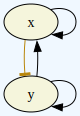

In [3]:
net_spec = """x : x + y : E
              y : (~x) y : E"""

network = DSGRN.Network(net_spec)

DSGRN.DrawGraph(network)

In [4]:
parameter_graph = DSGRN.ParameterGraph(network)

print('Number of parameter nodes:', parameter_graph.size())

Number of parameter nodes: 196


In [5]:
%%time

# Isomorphism classes
iso_classes = DSGRN_utils.IsomorphismQuery(network)

# Create isomorphic node classes to color the nodes
node_classes = {k: iso_classes[k] for k in range(len(iso_classes))}

CPU times: user 1.68 s, sys: 69.9 ms, total: 1.75 s
Wall time: 1.98 s


In [8]:
par_list = [0, 49, 98, 147]

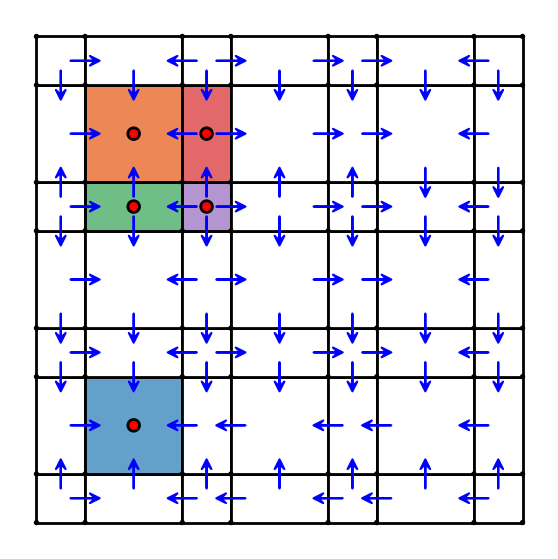

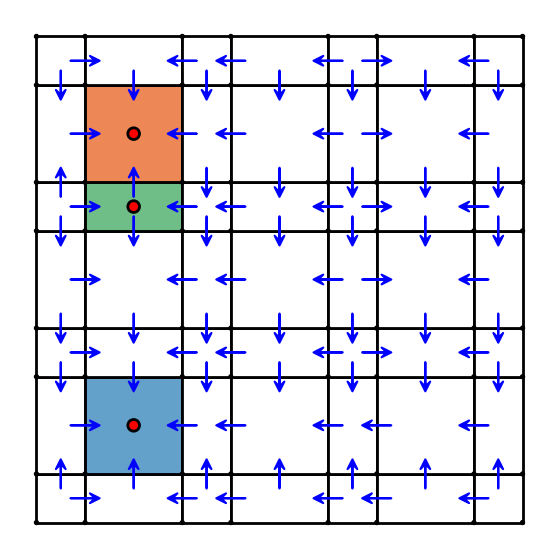

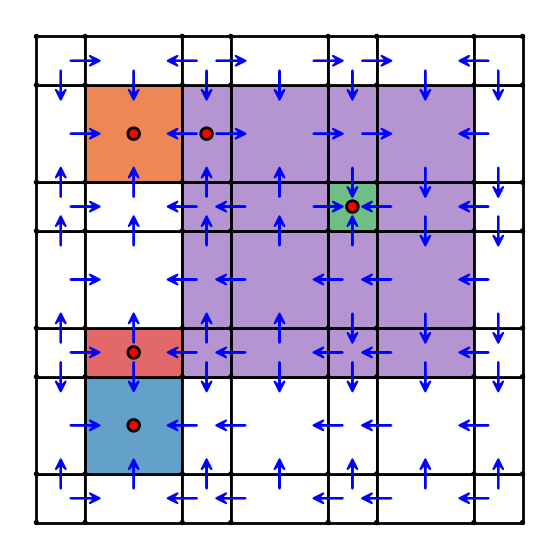

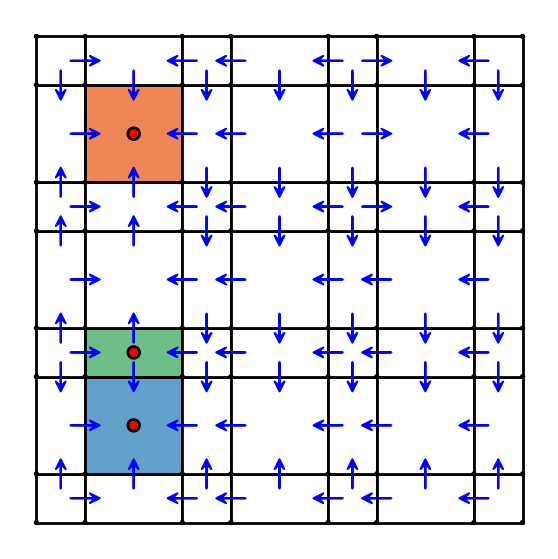

In [11]:
for par_index in par_list:
    parameter = parameter_graph.parameter(par_index)

    morse_graph, stg, graded_complex = DSGRN_utils.ConleyMorseGraph(parameter)

    DSGRN_utils.PlotMorseGraph(morse_graph)
    DSGRN_utils.PlotMorseSets(morse_graph, stg, graded_complex)

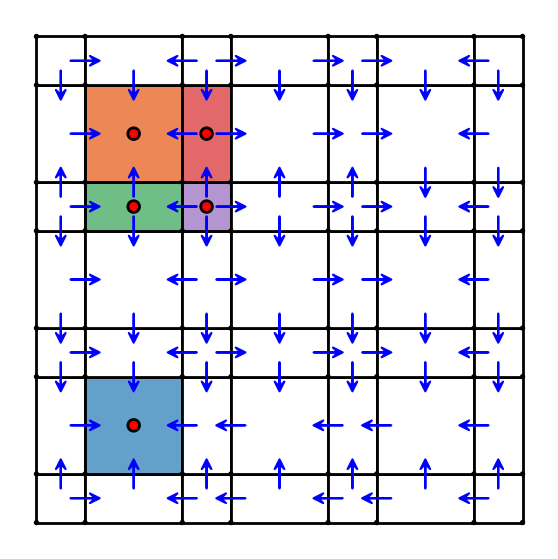

In [10]:
for par_index in par_list:
    parameter = parameter_graph.parameter(par_index)

    morse_graph, stg, graded_complex = DSGRN_utils.ConleyMorseGraph(parameter)

    DSGRN_utils.PlotMorseGraph(morse_graph)
    DSGRN_utils.PlotMorseSets(morse_graph, stg, graded_complex)

In [12]:
for par_index in par_list:
    print("Parameter:", par_index)
    parameter = parameter_graph.parameter(par_index)
    print(parameter.partialorders('T'))

Parameter: 0
x : (p0, p1, p2, T[x->x], T[x->y], p3)
y : (p0, p1, p2, T[y->x], T[y->y], p3)
Parameter: 49
x : (p0, p1, p2, T[x->y], T[x->x], p3)
y : (p0, p1, p2, T[y->x], T[y->y], p3)
Parameter: 98
x : (p0, p1, p2, T[x->x], T[x->y], p3)
y : (p0, p1, p2, T[y->y], T[y->x], p3)
Parameter: 147
x : (p0, p1, p2, T[x->y], T[x->x], p3)
y : (p0, p1, p2, T[y->y], T[y->x], p3)


In [19]:
par_index = 0
sampler = DSGRN.ParameterSampler(network)
par_sample = sampler.sample(parameter)

In [20]:
# Define L, U, and T from sample
D = network.size()
L = np.zeros([D, D])
U = np.zeros([D, D])
T = np.zeros([D, D])

# Get a dictionary from sample
sample_dict = json.loads(par_sample)

# Get values of L, U, and T from dictionary
for key, value in sample_dict['Parameter'].items():
    # Get parameter (L, U, or T)
    par_type = key[0]
    # Extract variable names
    node_names = [name.strip() for name in key[2:-1].split('->')]
    node_indices = [network.index(node) for node in node_names]
    if par_type == 'L':
        L[tuple(node_indices)] = value
    elif par_type == 'U':
        U[tuple(node_indices)] = value
    else: # T
        T[tuple(node_indices)] = value

In [21]:
print(parameter.inequalities())

{ "inequalities" : "(L[x->x] + L[y->x]) < T[x->y] && (U[x->x] + L[y->x]) < T[x->y] && (L[x->x] + U[y->x]) < T[x->y] && T[x->x] < (U[x->x] + U[y->x]) && 0 < T[x->y] < T[x->x] && 0 < L[x->x] < U[x->x] && 0 < L[y->x] < U[y->x] && L[x->y] L[y->y] < T[y->y] && U[x->y] L[y->y] < T[y->y] && L[x->y] U[y->y] < T[y->y] && T[y->x] < U[x->y] U[y->y] && 0 < T[y->y] < T[y->x] && 0 < L[x->y] < U[x->y] && 0 < L[y->y] < U[y->y]", "variables" : "{L[x->x], L[y->x], U[x->x], U[y->x], T[x->y], T[x->x], L[x->y], L[y->y], U[x->y], U[y->y], T[y->y], T[y->x]}"}


In [30]:
def hill_system(L, U, T, d):
    """
    Creates the system of differential equations with parameter d
    """
    # Create Hill functions
    h11 = HillFunction(L[0,0], U[0,0], T[0,0], d)
    h21 = HillFunction(L[1,0], U[1,0], T[1,0], d)
    h12 = HillFunction(U[0,1], L[1,0], T[1,0], d)
    h22 = HillFunction(L[1,1], U[1,1], T[1,1], d)

    def system(x):
        # x is a vector [x, y]
        x1, x2 = x
        
        # First equation: x'
        dx1 = -x1 + h11(x1) + h21(x2)
        
        # Second equation: y'
        dx2 = -x2 + h12(x1) * h22(x2)
        
        return np.array([dx1, dx2])
    
    def jacobian(x):
        x1, x2 = x
        
        # Compute derivatives
        dh11 = h11.derivative(x1)
        dh21 = h21.derivative(x2)
        dh12 = h12.derivative(x1)
        dh22 = h22.derivative(x2)
        
        # Jacobian matrix
        J = np.zeros((2, 2))
        
        # df1/dx1
        J[0,0] = -1 + dh11
        # df1/dx2
        J[0,1] = dh21
        
        # df2/dx1
        J[1,0] = dh12 * h22(x2)
        # df2/dx2
        J[1,1] = -1 + h12(x1) * dh22
        
        return np.array(J)
    
    return system, jacobian

In [25]:
d = 10.0

# Create the system
system = create_system(L, U, T, d)

# Try different initial conditions to find multiple zeros
initial_conditions = [
    np.array([0.0, 0.0]),
    np.array([1.0, 1.0]),
    np.array([0.5, 0.5]),
    np.array([0.0, 1.0]),
    np.array([1.0, 0.0])
]

zeros = []
for x0 in initial_conditions:
    x, converged, iters = newton_method_autodiff(system, x0)
    if converged:
        # Check if this zero is already found (within some tolerance)
        is_new = True
        for z in zeros:
            if np.allclose(z, x, rtol=1e-5):
                is_new = False
                break
        if is_new:
            zeros.append(x)
            print(f"Found zero at {x} after {iters} iterations")

print(f"\nTotal number of distinct zeros found: {len(zeros)}")

TypeError: HillFunction.__init__() takes 5 positional arguments but 6 were given